# Notes - using race and ethnicity for prevalence estimation


In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from graphviz import Digraph
from sympy.physics.units import magnetic_density
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

In [2]:
con = duckdb.connect("./data/us_births.db")  # , read_only=True)

In [3]:
prev_est_df = pd.read_csv(
    "./us-births-estimated-prevalence-ethnicity-2000-2018.csv"
).convert_dtypes()
prev_est_df

,year,mracehisp_c,prevalence
0,2000,1,12.128999
1,2000,2,10.499449
2,2000,5,11.964842
3,2000,4,9.429186
4,2000,3,7.624409
...,...,...,...
90,2018,1,12.647556
91,2018,2,13.171963
92,2018,5,16.76941
93,2018,4,8.871391


In [4]:
con.execute("DROP TABLE IF EXISTS us_births_est_prevalence_ethnicity;")
con.execute(
    """
CREATE TABLE us_births_est_prevalence_ethnicity AS
SELECT * FROM prev_est_df
"""
)

In [5]:
con.execute(
    """
    SELECT 
    * FROM us_births_est_prevalence_ethnicity;
    """
).df()

,year,mracehisp_c,prevalence
0,2000,1,12.128999
1,2000,2,10.499449
2,2000,5,11.964842
3,2000,4,9.429186
4,2000,3,7.624409
...,...,...,...
90,2018,1,12.647556
91,2018,2,13.171963
92,2018,5,16.769410
93,2018,4,8.871391


In [14]:
year_counts_df = con.execute(
    """
    SELECT 
        b.year,
        sum(b.p_ds_lb_wt) as p_ds_lb_wt,
        sum(e.prevalence / 10000.0) as p_ds_lb_wt_eth,
        sum(b.p_ds_lb_nt) as p_ds_lb_nt,
        sum(down_ind)
    FROM us_births b 
        JOIN us_births_est_prevalence_ethnicity e 
            ON b.year = e.year AND b.mracehisp_c = e.mracehisp_c
    GROUP BY b.year;
    """
).df()
year_counts_df.to_csv(f"./output/us_births_prevalence_estimates_year.csv", index=False)
year_counts_df

,year,p_ds_lb_wt,p_ds_lb_wt_eth,p_ds_lb_nt,sum(down_ind)
0,2000,4614.243822,4689.291202,6888.592290,1843.0
1,2001,4717.698939,4796.351616,6976.855099,1785.0
2,2002,4859.861952,5002.850364,7063.166126,1836.0
3,2003,4958.261777,5072.546820,7290.996035,1866.0
4,2004,4977.062244,5103.681130,7369.341710,1924.0
5,2005,5087.039808,5224.713153,7428.674202,1991.0
6,2006,5277.990952,5344.912451,7596.517155,2080.0
7,2007,5413.457868,5428.735746,7678.114649,2034.0
8,2008,5307.422301,5288.117667,7617.187662,1992.0
9,2009,5184.316192,5201.551787,7488.835284,1986.0


In [7]:
year_counts_df.describe()

,year,p_ds_lb_wt,p_ds_lb_wt_eth
count,19.000000,19.000000,17.000000
mean,2009.000000,5036.818293,5100.513360
std,5.627314,191.806334,190.319583
min,2000.000000,4614.243822,4689.291202
25%,2004.500000,4964.795168,5002.850364
50%,2009.000000,5004.697357,5072.546820
75%,2013.500000,5145.545367,5224.713153
max,2018.000000,5413.457868,5428.735746


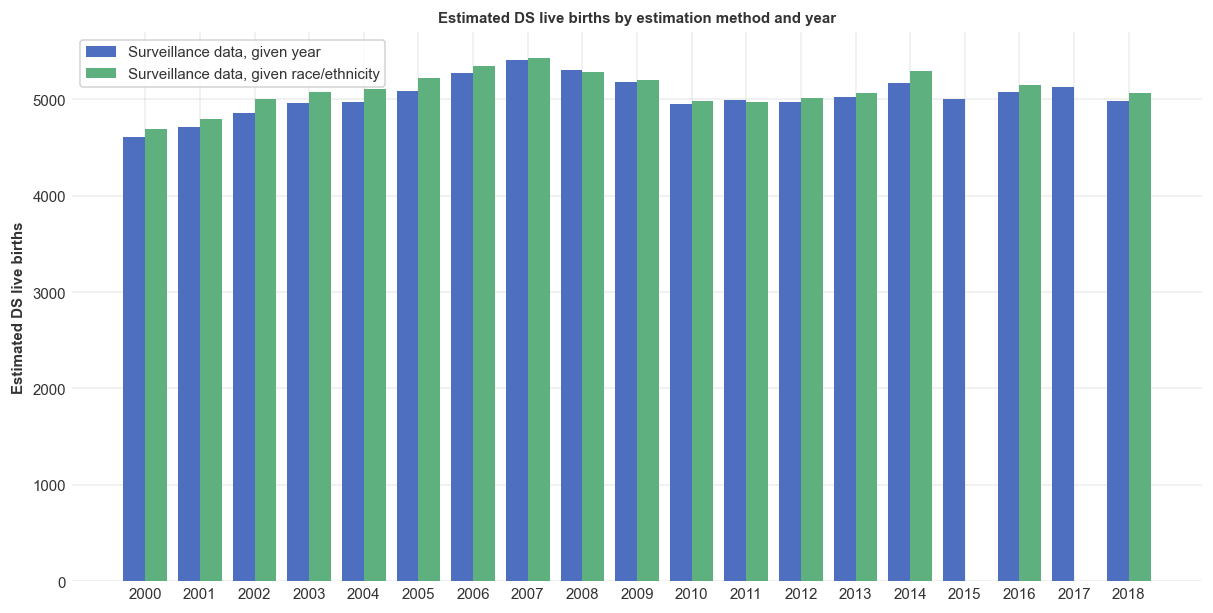

In [8]:
# plot bar chart of p_ds_lb_wt and prev by year
fig, axs = plt.subplots(figsize=(10, 5))

x = np.arange(len(year_counts_df["year"]))  # numeric positions for each year
width = 0.4  # width of each bar

axs.bar(
    x - width / 2,
    year_counts_df["p_ds_lb_wt"],
    width=width,
    label="Surveillance data, given year",
)
axs.bar(
    x + width / 2,
    year_counts_df["p_ds_lb_wt_eth"],
    width=width,
    label="Surveillance data, given race/ethnicity",
)
axs.set_ylabel("Estimated DS live births")
axs.set_title("Estimated DS live births by estimation method and year")
axs.set_xticks(x)
axs.set_xticklabels(year_counts_df["year"])
axs.legend()

In [9]:
prev_est_year_race_df = con.execute(
    """
    SELECT *
    FROM (
        SELECT 
            b.year,
            b.mracehisp_c,
            SUM(b.p_ds_lb_wt) AS prev_est_year
        FROM us_births b
        JOIN us_births_est_prevalence_ethnicity e
        ON b.year = e.year 
        AND b.mracehisp_c = e.mracehisp_c
        GROUP BY b.year, b.mracehisp_c
    )
    PIVOT (
        SUM(prev_est_year) 
        FOR mracehisp_c IN (
            '1' AS nh_white,
            '2' AS nh_black,
            '3' AS ai_an,
            '4' AS nh_asian_pi,
            '5' AS hispanic
        )
    )
    ORDER BY year;
    """
).df()

prev_est_year_race_df

,year,nh_white,nh_black,ai_an,nh_asian_pi,hispanic
0,2000,2715.058275,694.393554,43.758516,223.590804,937.442673
1,2001,2743.038999,695.515680,44.822043,229.976919,1004.345298
2,2002,2794.562560,703.255360,46.719936,249.318912,1066.005184
3,2003,2830.909299,702.318317,47.022925,259.230102,1118.781134
4,2004,2798.023704,705.144048,48.114654,265.901580,1159.878258
5,2005,2818.398888,721.718940,49.994964,270.912660,1226.014356
6,2006,2872.659728,768.101580,52.535364,283.763864,1300.930416
7,2007,2913.945281,791.090872,54.105727,305.412939,1348.903049
8,2008,2851.241787,783.367428,53.394846,302.275818,1317.142422
9,2009,2792.843860,769.551194,52.423480,300.109910,1269.387748


In [10]:
prev_est_ethn_race_df = con.execute(
    """
    SELECT *
    FROM (
        SELECT 
            b.year,
            b.mracehisp_c,
            sum(e.prevalence / 10000.0) AS prev_est_race
        FROM us_births b
        JOIN us_births_est_prevalence_ethnicity e
        ON b.year = e.year 
        AND b.mracehisp_c = e.mracehisp_c
        GROUP BY b.year, b.mracehisp_c
    )
    PIVOT (
        SUM(prev_est_race) 
        FOR mracehisp_c IN (
            '1' AS nh_white,
            '2' AS nh_black,
            '3' AS ai_an,
            '4' AS nh_asian_pi,
            '5' AS hispanic
        )
    )
    ORDER BY year;
    """
).df()

prev_est_ethn_race_df

,year,nh_white,nh_black,ai_an,nh_asian_pi,hispanic
0,2000,2866.052252,634.530016,29.036797,183.488191,976.183945
1,2001,2867.243316,635.421039,27.679651,192.770651,1073.236959
2,2002,2936.332594,664.400106,44.454273,208.091765,1149.571626
3,2003,2966.614965,648.501593,45.381082,220.397370,1191.651810
4,2004,2916.483778,670.540996,43.167689,212.442814,1261.045853
5,2005,2961.368962,701.215843,42.403534,215.035857,1304.688957
6,2006,2942.949211,747.015302,44.029637,200.788805,1410.129495
7,2007,2967.210253,753.074475,48.564880,224.771888,1435.114250
8,2008,2964.880583,746.511983,49.734454,232.193133,1294.797515
9,2009,2796.417676,725.147488,48.999941,232.345075,1398.641607


C:\Users\FrankBuckley\AppData\Local\Temp\ipykernel_22524\3495118878.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.98])


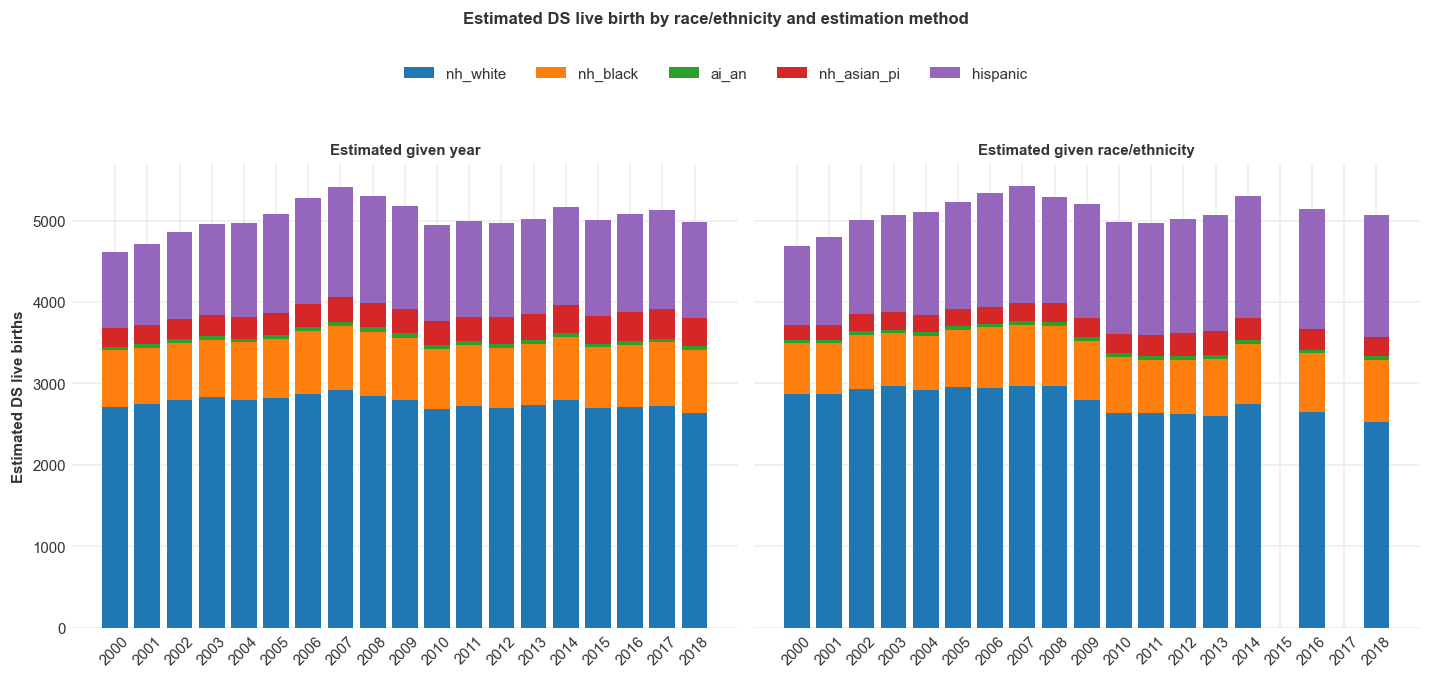

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
races = ["nh_white", "nh_black", "ai_an", "nh_asian_pi", "hispanic"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

bottom = np.zeros(len(prev_est_year_race_df))
for race, color in zip(races, colors):
    axs[0].bar(
        prev_est_year_race_df["year"],
        prev_est_year_race_df[race],
        bottom=bottom,
        label=race,
        color=color,
    )
    bottom += prev_est_year_race_df[race]

axs[0].set_ylabel("Estimated DS live births")
axs[0].set_title("Estimated given year")
axs[0].set_xticks(prev_est_year_race_df["year"])
axs[0].tick_params(axis="x", rotation=45)

bottom = np.zeros(len(prev_est_ethn_race_df))
for race, color in zip(races, colors):
    axs[1].bar(
        prev_est_ethn_race_df["year"],
        prev_est_ethn_race_df[race],
        bottom=bottom,
        label=race,
        color=color,
    )
    bottom += prev_est_ethn_race_df[race]

axs[1].set_title("Estimated given race/ethnicity")
axs[1].set_xticks(prev_est_ethn_race_df["year"])
axs[1].tick_params(axis="x", rotation=45)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(races),
    frameon=False,
)

fig.suptitle("Estimated DS live birth by race/ethnicity and estimation method", y=1.12)
fig.tight_layout(rect=[0, 0, 1, 0.98])